In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.models, icepack.plot

# Synthetic ice sheet - "Ashtray model"

In this demo we'll run an experiment inspired by the paper [*Fjord insertion into continental margins
driven by topographic steering of ice*](https://www.nature.com/articles/ngeo201) by Kessler and others.
This work simulated the evolution of an entire ice sheet on millenial timescales, with the added twist that the bedrock topography could evolve under the influence of erosion.

### Geometry

The model domain is a circle 250 km wide, but with a 1km-high ridge at a radius of 200 km.
This ridge is punctuated by four valleys of varying depths from which ice streams form!

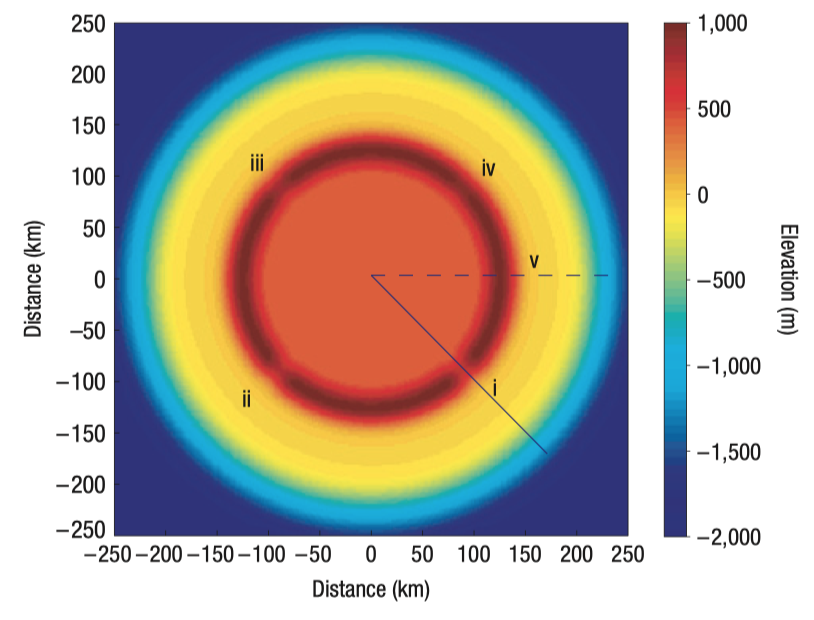

In [2]:
# For testing only
#R = 250e3
#δx = 15e3
#r = 125e3 

In [3]:
import pygmsh

R = 250e3
δx = 15e3

geometry = pygmsh.built_in.Geometry()

points = [geometry.add_point([+R, 0, 0], lcar=δx),
          geometry.add_point([0, +R, 0], lcar=δx),
          geometry.add_point([-R, 0, 0], lcar=δx),
          geometry.add_point([0, -R, 0], lcar=δx)]
center = geometry.add_point([0, 0, 0], lcar=δx)

arcs = [geometry.add_circle_arc(points[k], center, points[(k + 1) % len(points)])
        for k in range(len(points))]

line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

Now we're going to do some fancy tricks to make the mesh more refined around the mountain range.
First, we'll make some circular arcs around the radius of 200km.
We won't put these arcs in any physical entity, so they won't get included in the output geometry; they're just there as a cue for later geometric constructions.

In [4]:
r = 125e3
cpoints = [geometry.add_point([+r, 0, 0], lcar=δx),
           geometry.add_point([0, +r, 0], lcar=δx),
           geometry.add_point([-r, 0, 0], lcar=δx),
           geometry.add_point([0, -r, 0], lcar=δx)]

carcs = [geometry.add_circle_arc(cpoints[k], center, cpoints[(k + 1) % len(cpoints)])
         for k in range(len(cpoints))]

Then we'll add a bit of text to the end of the code for the geometry that creates field objects.
The value of this field transitions from the characteristic length of 15km throughout most of the domain down to 1km in the neighborhood of the mountain range.
Finally, we'll set this as the background field determining the mesh's characteristic length scale and turn off all the other built-in methods for setting the characteristic length.

In [5]:
code = geometry.get_code()

code += """
lc = {lc:};

Field[1] = Distance;
Field[1].NNodesByEdge = 100;
Field[1].EdgesList = {{{edges:}}};

Field[2] = Threshold;
Field[2].IField = 1;
Field[2].LcMin = lc / {shrink_factor:};
Field[2].LcMax = lc;
Field[2].DistMin = {dist_min:};
Field[2].DistMax = {dist_max:};

Background Field = 2;

Mesh.CharacteristicLengthExtendFromBoundary = 0;
Mesh.CharacteristicLengthFromPoints = 0;
Mesh.CharacteristicLengthFromCurvature = 0;
""".format(edges=', '.join([arc.id for arc in carcs]), lc=δx, shrink_factor=5.,
           dist_min=40e3, dist_max=60e3)

with open('ice-sheet.geo', 'w') as geo_file:
    geo_file.write(code)

You can see the result by plotting the mesh -- everything is much more refined around the mountain range.

In [6]:
!gmsh -2 -format msh2 -o ice-sheet.msh ice-sheet.geo

Info    : Running 'gmsh -2 -format msh2 -o ice-sheet.msh ice-sheet.geo' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Thu May 14 17:30:05 2020
Info    : Reading 'ice-sheet.geo'...
Info    : Done reading 'ice-sheet.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Done meshing 1D (0.002028 s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Delaunay)
Info    : Done meshing 2D (0.405779 s)
Info    : 11299 vertices 22339 elements
Info    : Writing 'ice-sheet.msh'...
Info    : Done writing 'ice-sheet.msh'
Info    : Stopped on Thu May 14 17:30:05 2020


In [7]:
mesh = firedrake.Mesh('ice-sheet.msh')

In [8]:
# My plotting in icepack isn't working right now...
#fig, axes = icepack.plot.subplots()
#icepack.plot.tricontourf(mesh)

Now we build up a bed topography on this mesh. 

In [9]:
from firedrake import exp, sqrt
x, y = firedrake.SpatialCoordinate(mesh)

def tanh(z):
    return (exp(z) - exp(-z)) / (exp(z) + exp(-z))

def θ(z):
    return (tanh(z) + 1) / 2

def sech(z):
    return 2 / (exp(z) + exp(-z))

b0 = firedrake.Constant(400)
h0 = firedrake.Constant(1000)

a = firedrake.Constant(50e3)
ξ = (sqrt(x**2 + y**2) - r) / a

ρ1 = firedrake.Constant(1/4)
μ1 = 1 - ρ1 * θ(3 * (x - r/4) / a) * sech(2 * y / a)

ρ2 = firedrake.Constant(3/8)
μ2 = 1 - ρ2 * θ(3 * (y - r/4) / a) * sech(2 * x / a)

ρ3 = firedrake.Constant(1/2)
μ3 = 1 - ρ3 * θ(3 * (-x + r/4) / a) * sech(2 * y / a)

ρ4 = firedrake.Constant(5/8)
μ4 = 1 - ρ4 * θ(3 * (-y + r/4) / a) * sech(2 * x / a)

μ = μ1 * μ2 * μ3 * μ4

Ro = firedrake.Constant(200e3)
ζ = (sqrt(x**2 + y**2) - Ro) / Ro
S = 480 / (1 - Ro / R)
b_expr = b0 * (1 - θ(3 * ξ)) + (h0 - b0) * sech(3 * ξ) * μ - θ(5 * ζ) * S * ζ

Define fucntion spaces on the mesh and interpolate the bed expression onto the mesh.

In [10]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2)
b = firedrake.interpolate(b_expr, Q)

In [11]:
# Icepack plotting not working...
#fig, axes = icepack.plot.subplots()
#contours = icepack.plot.tricontourf(b, 40, cmap='magma', axes=axes)
#fig.colorbar(contours)

<IPython.core.display.Javascript object>


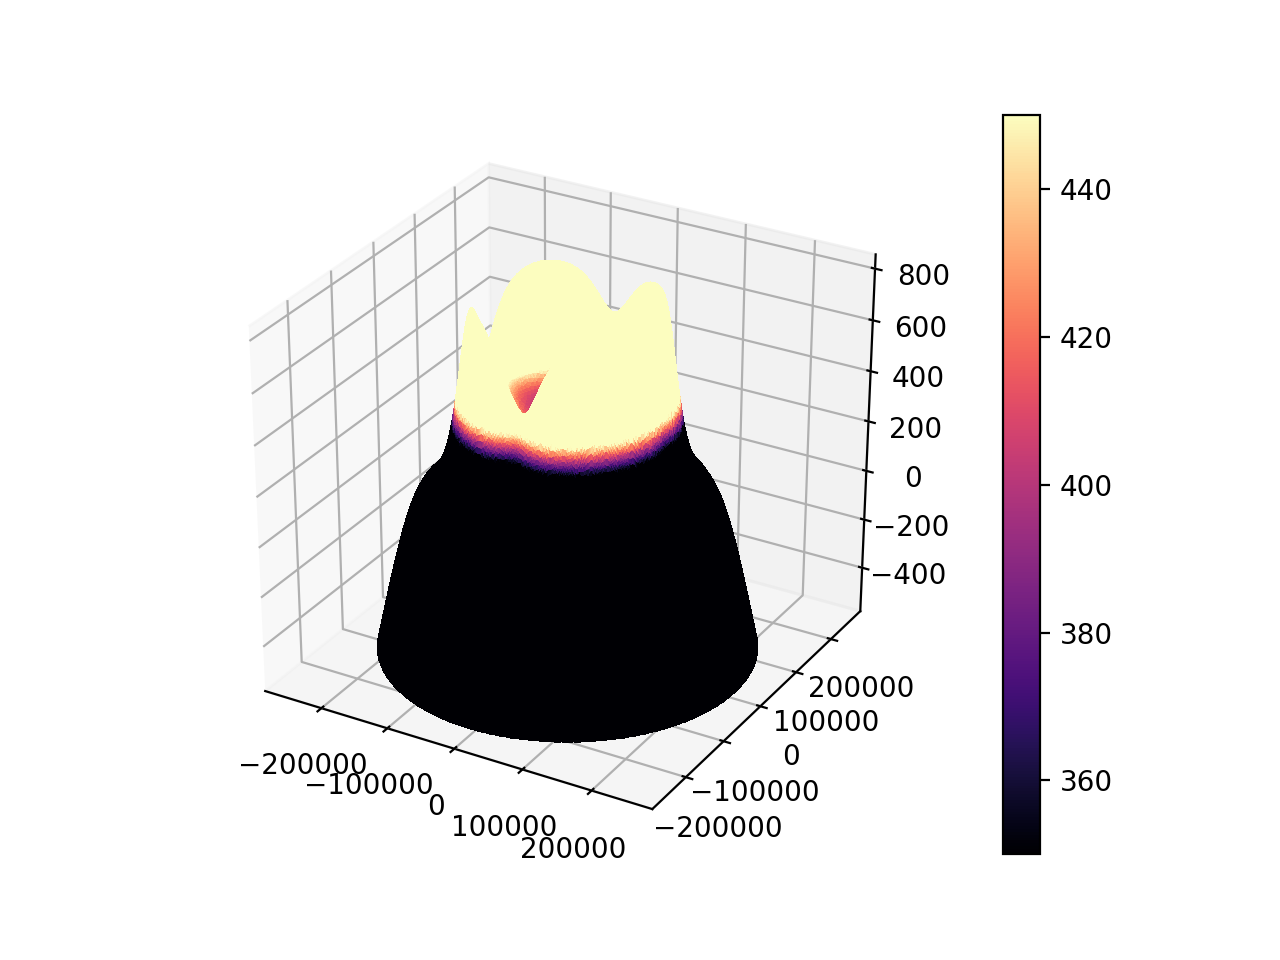

In [12]:
firedrake.plot(b, cmap='magma', vmin=350, vmax=450, plot3d=True)

Now we'll try growing an ice sheet. We'll start with a simple, unrealistic ice sheet and let it relax and grow according to the shallow ice approximation. 

First define some functions that we'll use to know where the ice is (ice_mask), compute the surface elevation from the bed elevation and ice thickness (surface), and compute the mass balance over the ice sheet according to Kessler et al. (2008) (mass_balance).

In [13]:
def ice_mask(h_expr):
    return h_expr / (h_expr + 1e-10)

def surface(h_expr, b):
    mask = ice_mask(h_expr)
    return (b*mask) + h_expr

def mass_balance(s_expr, h_expr):
    # As specified in Kessler et al. (2008), the mass balance is a function of elevation 
    # and linearly increases by 0.5 m/km. The equilibrium line altitude is at 300 m. 
    # The maximum allowable mass balance is 0.5 m. No mimimum mass balance is specified.
    a = firedrake.max_value((s0_expr - 300) * 0.5/1000, 0.5/1000) / icepack.constants.year
    mask = ice_mask(h_expr)
    return a * mask

Import the shallow ice model from icepack. Then set up some things we'll need before we can run the model. 

In [14]:
shallow_ice = icepack.models.ShallowIce()

In [15]:
# Time Step
dt = icepack.constants.year / 6 # two months
num_tsteps = 12 # 2 years

# File Names
infile = ""
outfile = "2yrs_2mon_from0"

# Velocity
u0_filename = "u_%s" % infile
u_filename = "u_%s" % outfile
try:
    # try importing a velocity file
    with firedrake.DumbCheckpoint(u0_filename, mode=0) as chk:
        u0_expr = firedrake.Function(V)
        chk.load(u0_expr, name="u");
        u0 = firedrake.interpolate(u0_expr, V)
except:
    # if there is no velocity file, then we'll compute it ourselves
    print('no velocity file imported')
    u0 = firedrake.Function(V)

# Thickness
h0_filename = "h_%s" % infile
h_filename = "h_%s" % outfile
try:
    # try importing a thickness file
    with firedrake.DumbCheckpoint(h0_filename, mode=0) as chk:
        h0_expr = firedrake.Function(Q)
        chk.load(h0_expr, name="h");
except:
    # if there is no thickness file, then we'll start with a small, simple, unrealistic ice mound
    print('no thickness file imported')
    h0_expr = firedrake.max_value(.5 - ((x / 1e5)**2 + (y / 1e5)**2), 0) * 1000
h0 = firedrake.interpolate(h0_expr, Q)

# Surface Elevation
s0_expr = surface(h0_expr, b)
s0 = firedrake.interpolate(s0_expr,Q)

# Mass Balance
a = mass_balance(s0_expr, h0_expr)

# Other things
T = firedrake.Constant(255.15)
A = icepack.rate_factor(T)

no velocity file imported
no thickness file imported


I found that I needed to mask the surface elevation to just cover the ice sheet. If I don't do this, then the bedrock starts to flow as if it is ice. I'm not sure the best way to do the masking, but I settled on setting everything that is not ice to zero. This puts a funny cliff at the edge of the ice sheet, but it's not obvious if it has much of an impact on the results.

<IPython.core.display.Javascript object>


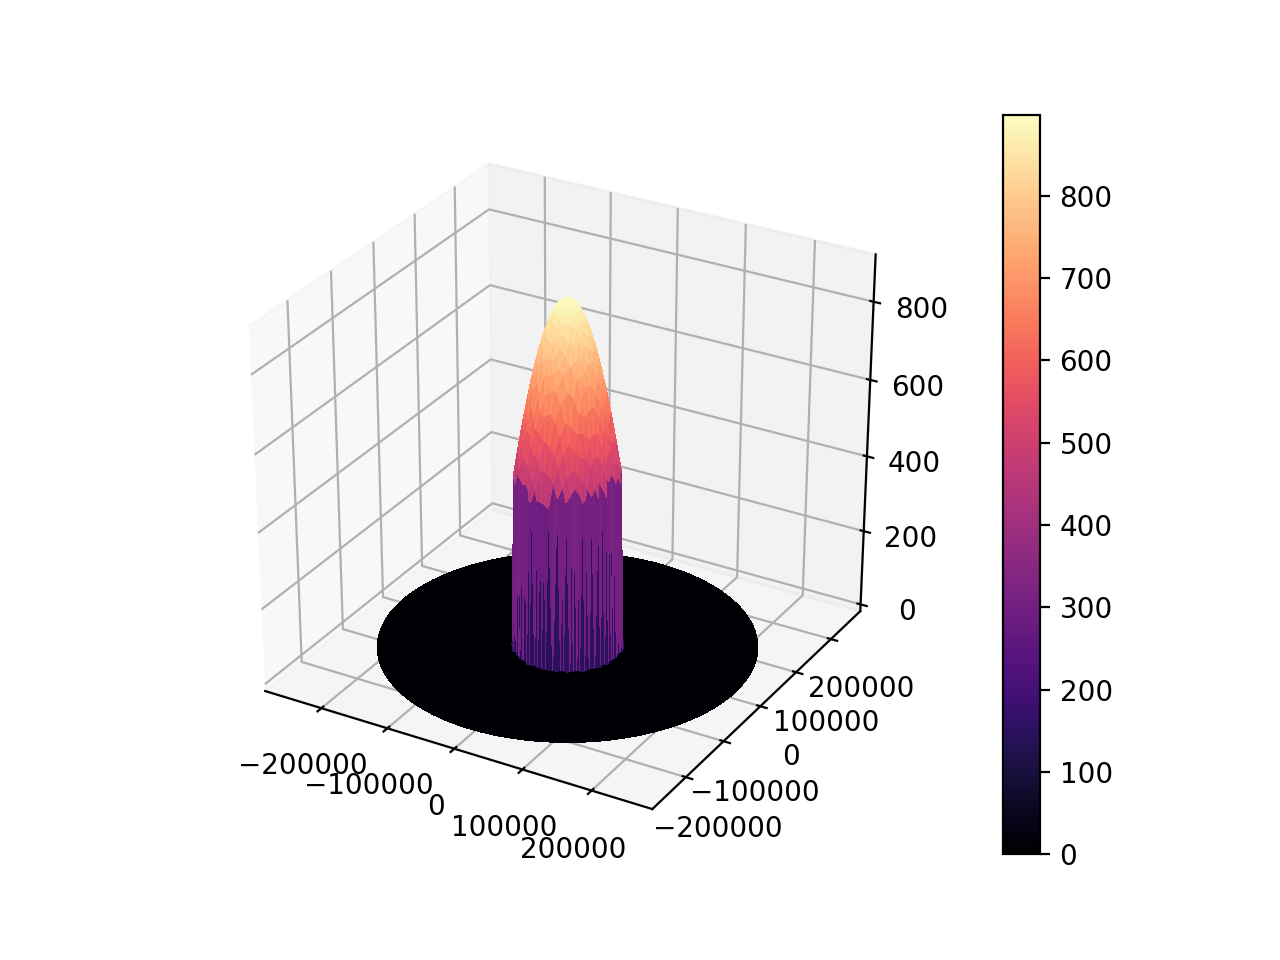

In [16]:
firedrake.plot(s0, cmap='magma', plot3d=True)

Now we can run the model forward 2 years (using 2 month time steps).

In [17]:
# First time step
u = shallow_ice.diagnostic_solve(u0=u0, h=h0, s=s0, A=A)
h = shallow_ice.prognostic_solve(dt=dt, h0=h0, a=a, u=u, h_inflow=None)

# Following time steps
for t in range(1,num_tsteps):
    s_expr = surface(h, b)
    s = firedrake.interpolate(s_expr,Q)
    a = mass_balance(s_expr, h)
    u = shallow_ice.diagnostic_solve(u0=u, h=h, s=s, A=A)
    h = shallow_ice.prognostic_solve(dt=dt, h0=h, a=a, u=u, h_inflow=None)
    
# Save variables with checkpointing
if outfile:
    with firedrake.DumbCheckpoint(h_filename, mode=1) as chk:
        chk.store(firedrake.interpolate(h,Q), name="h")

    with firedrake.DumbCheckpoint(u_filename, mode=1) as chk:
        chk.store(firedrake.interpolate(u,V), name="u")

<IPython.core.display.Javascript object>


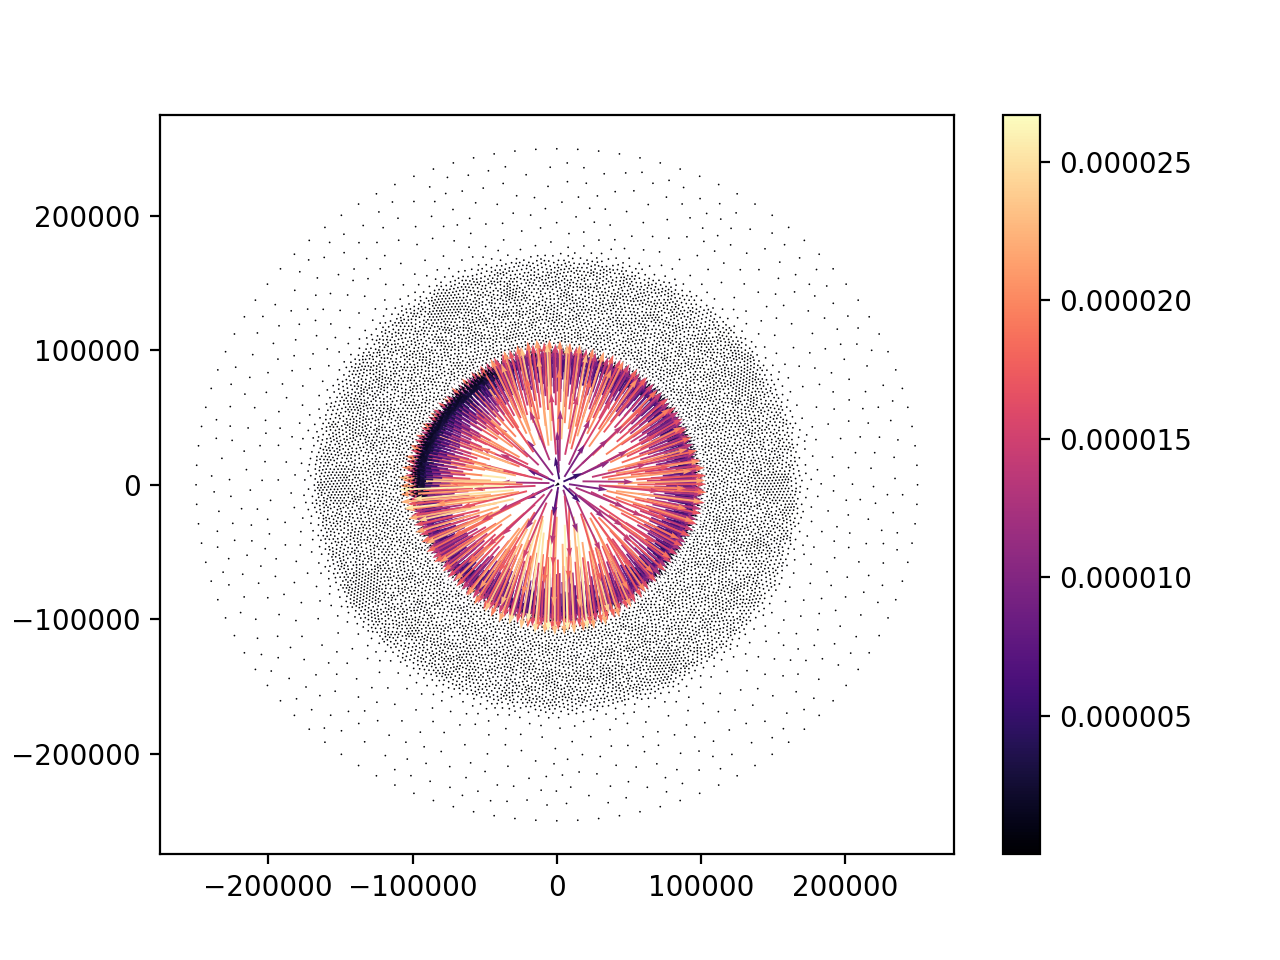

In [18]:
firedrake.plot(firedrake.interpolate(u,V), cmap='magma', plot3d=True)

Now let's look at a longer run I saved with checkpointing. This was run for 200 years.

<IPython.core.display.Javascript object>


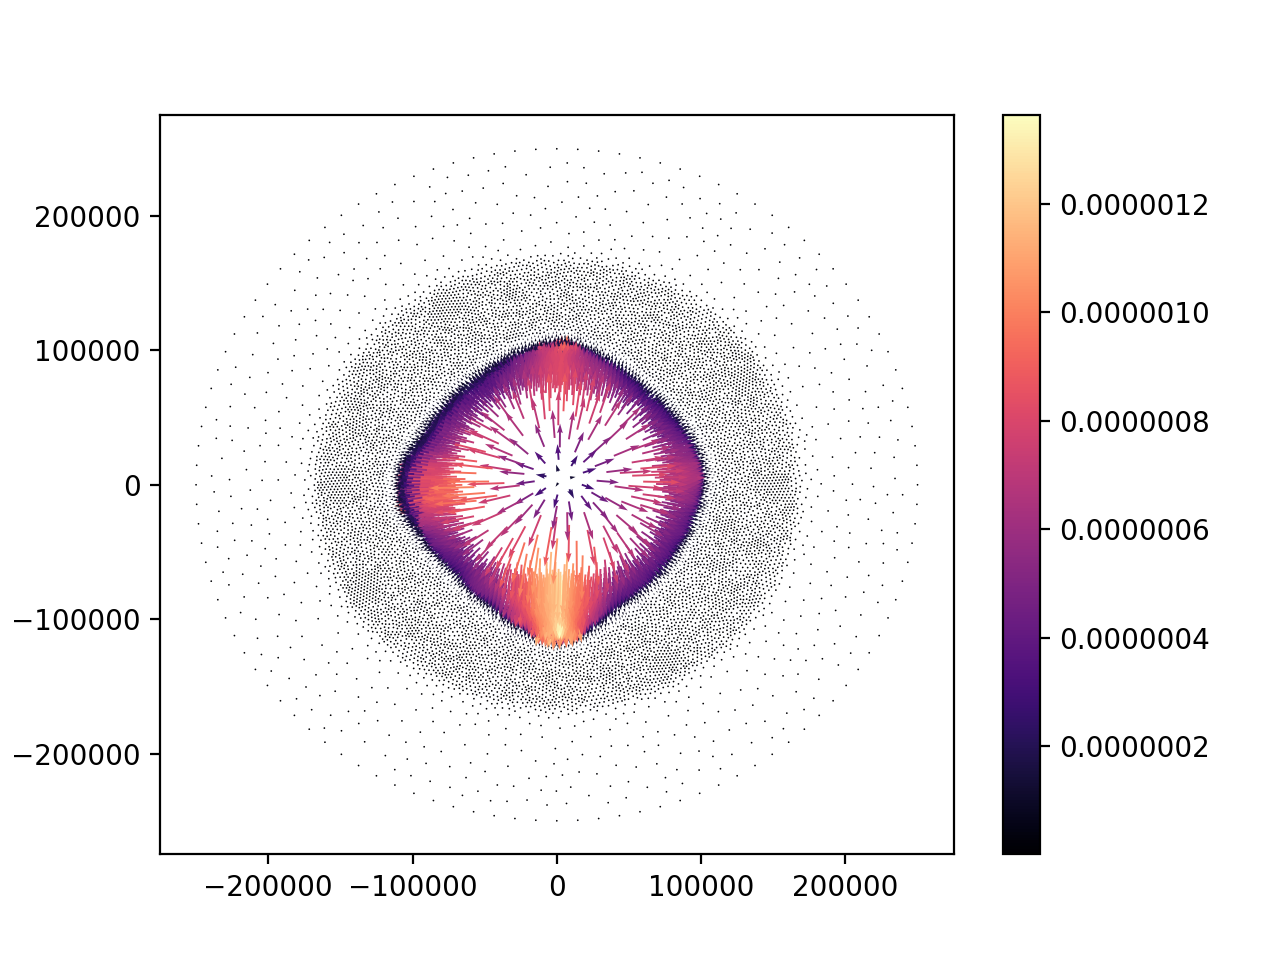

In [19]:
with firedrake.DumbCheckpoint("u_200yrs_2mon_from0", mode=0) as chk:
    u_expr = firedrake.Function(V)
    chk.load(u_expr, name="u");

firedrake.plot(firedrake.interpolate(u_expr,V), cmap='magma', plot3d=True)

<IPython.core.display.Javascript object>


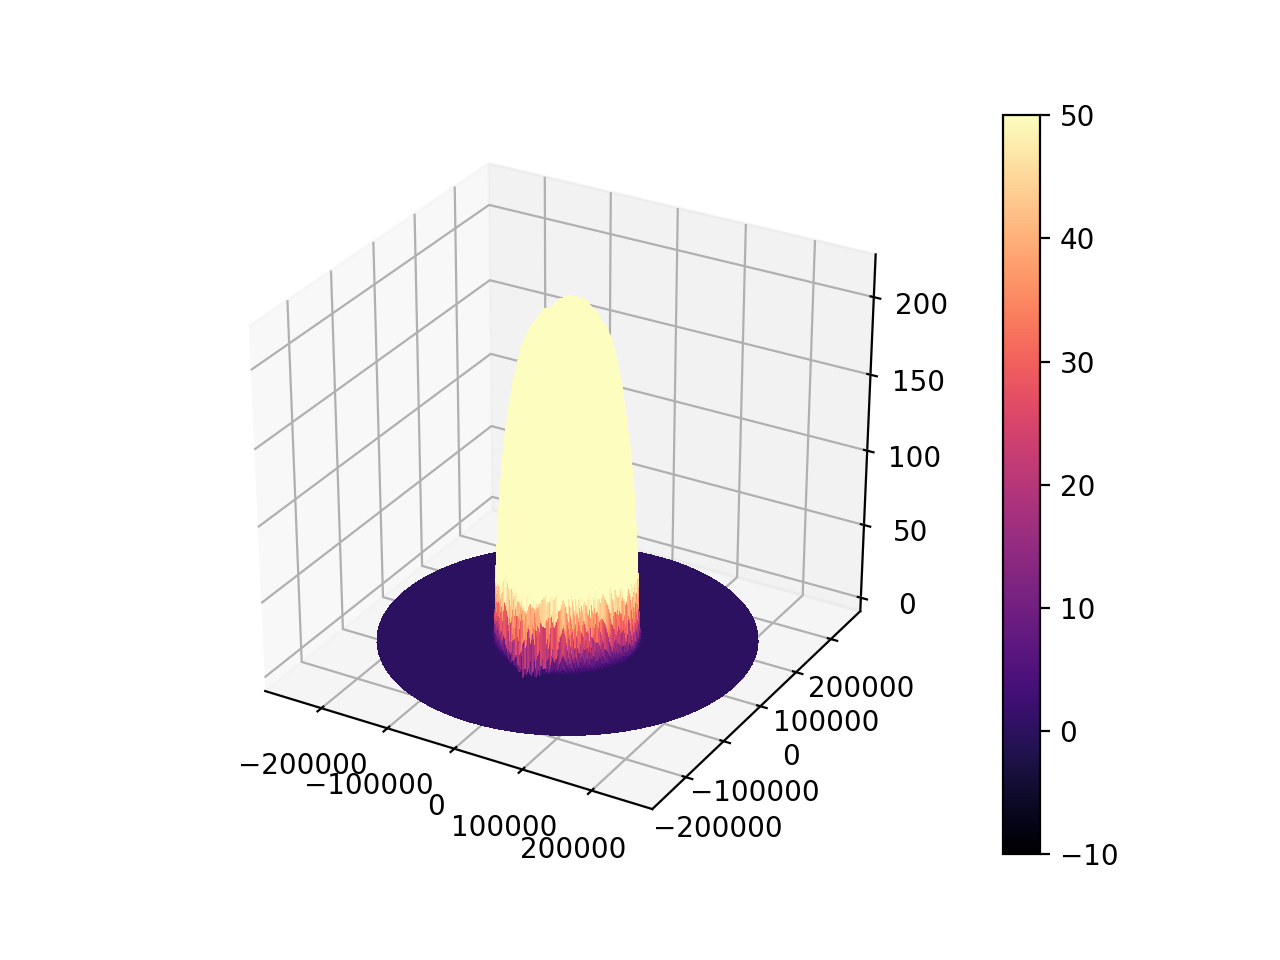

In [20]:
with firedrake.DumbCheckpoint("h_200yrs_2mon_from0", mode=0) as chk:
    h_expr = firedrake.Function(Q)
    chk.load(h_expr, name="h");
    
#firedrake.plot(firedrake.interpolate(h_expr,Q), cmap='magma', plot3d=True)
firedrake.plot(firedrake.interpolate(h_expr,Q), vmin=-10, vmax=50, cmap='magma', plot3d=True)

<IPython.core.display.Javascript object>


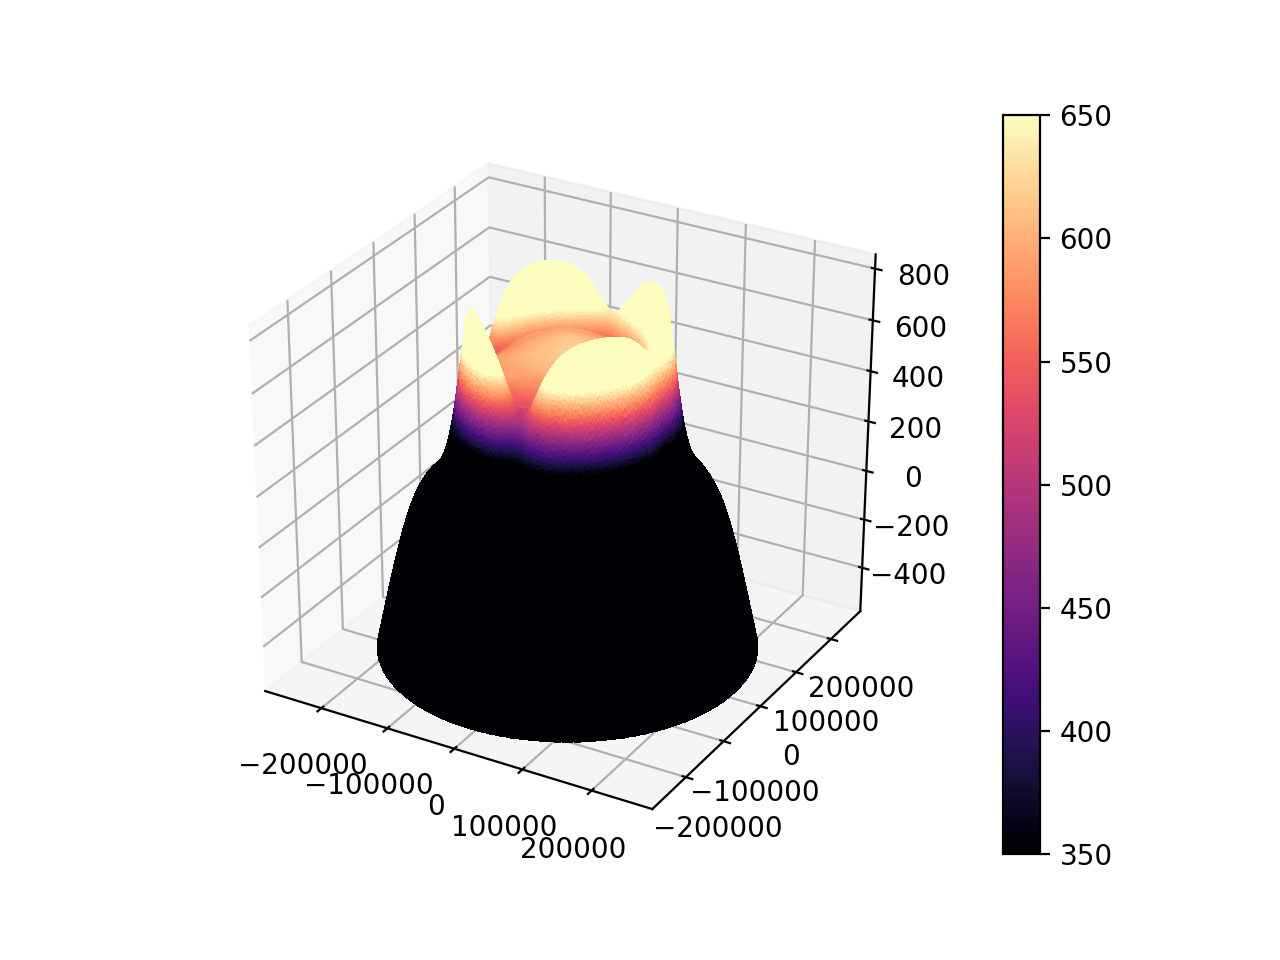

In [23]:
s_expr = h_expr + b

#firedrake.plot(firedrake.interpolate(s,Q), cmap='magma', plot3d=True)
firedrake.plot(firedrake.interpolate(s_expr,Q), vmin=350 , vmax=650 ,cmap='magma', plot3d=True)

I'm having trouble starting from a checkpoint file. Here, I've started from a checkpoint file at year 100 and run for another 100 years to get a total of 200 years of simulation.

<IPython.core.display.Javascript object>


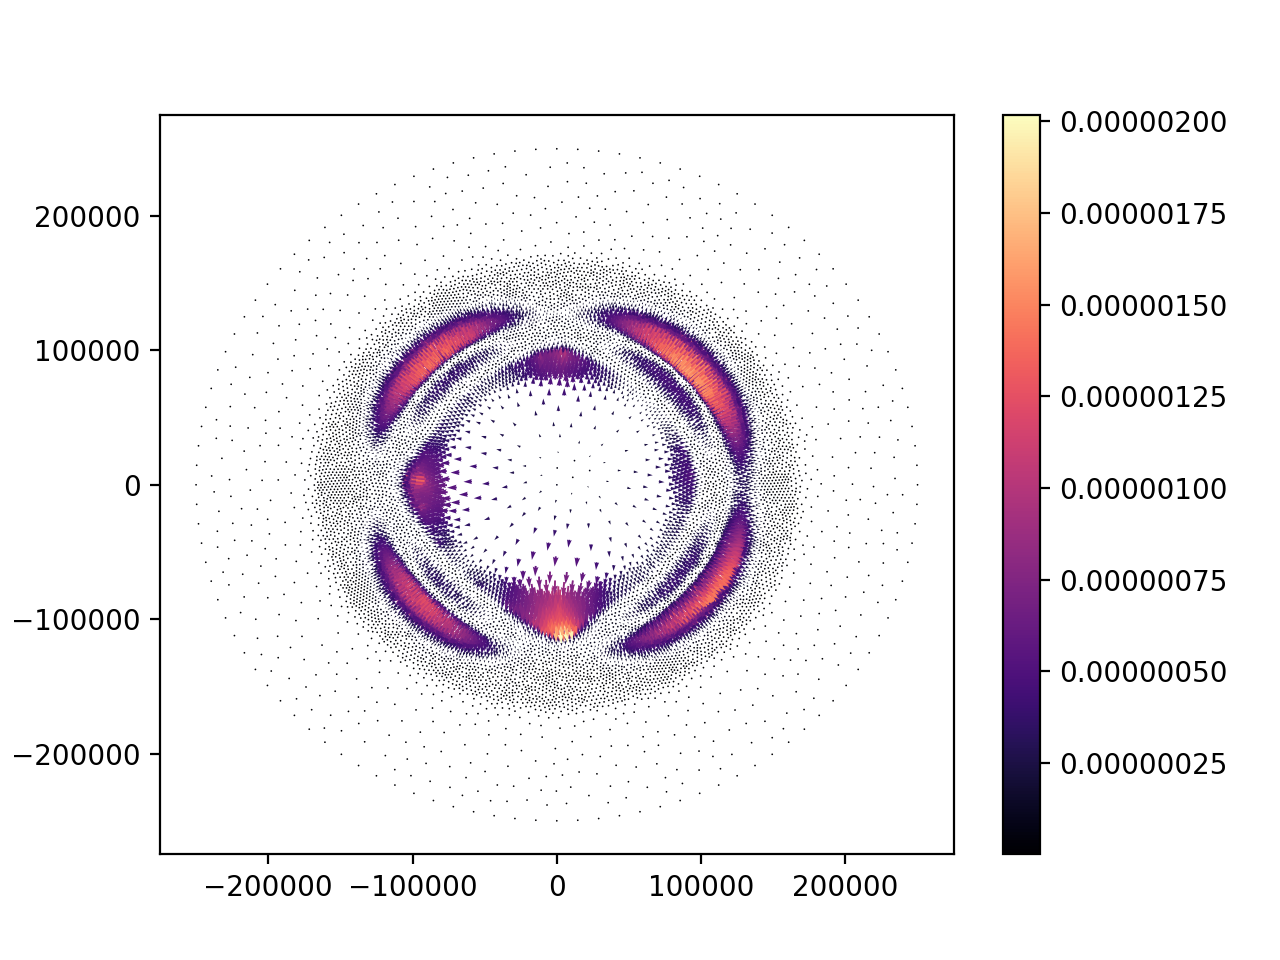

In [22]:
with firedrake.DumbCheckpoint("u_200yrs_2mon_from100", mode=0) as chk:
    u_expr = firedrake.Function(V)
    chk.load(u_expr, name="u");

firedrake.plot(firedrake.interpolate(u_expr,V), cmap='magma', plot3d=True)